# Berater Environment v13

## Changes from v12 (work in progress)
* migration to easyagents

### Install gym

In [3]:
!pip install gym==0.10.11 > /dev/null

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


# Define Gym Environment

### Imports

In [4]:
import numpy as np
import random

import gym
from gym.utils import seeding
from gym import spaces

import pdb

### Helper methods

In [5]:
def state_name_to_int(state):
    state_name_map = {
        'S': 0,
        'A': 1,
        'B': 2,
        'C': 3,
        'D': 4,
        'E': 5,
        'F': 6,
        'G': 7,
        'H': 8,
        'K': 9,
        'L': 10,
        'M': 11,
        'N': 12,
        'O': 13
    }
    return state_name_map[state]

def int_to_state_name(state_as_int):
    state_map = {
        0: 'S',
        1: 'A',
        2: 'B',
        3: 'C',
        4: 'D',
        5: 'E',
        6: 'F',
        7: 'G',
        8: 'H',
        9: 'K',
        10: 'L',
        11: 'M',
        12: 'N',
        13: 'O'
    }
    return state_map[state_as_int]
    


### Berater Environment (OpenAI Gym)

In [6]:
class BeraterEnv(gym.Env):
    """
    The Berater Problem

    Actions: 
    There are 4 discrete deterministic actions, each choosing one direction
    """
    metadata = {'render.modes': ['ansi']}
    
    showStep = False
    showDone = True
    envEpisodeModulo = 100

    def __init__(self):
#         self.map = {
#             'S': [('A', 100), ('B', 400), ('C', 200 )],
#             'A': [('B', 250), ('C', 400), ('S', 100 )],
#             'B': [('A', 250), ('C', 250), ('S', 400 )],
#             'C': [('A', 400), ('B', 250), ('S', 200 )]
#         }
        self.map = {
            'S': [('A', 300), ('B', 100), ('C', 200 )],
            'A': [('S', 300), ('B', 100), ('E', 100 ), ('D', 100 )],
            'B': [('S', 100), ('A', 100), ('C', 50 ), ('K', 200 )],
            'C': [('S', 200), ('B', 50), ('M', 100 ), ('L', 200 )],
            'D': [('A', 100), ('F', 50)],
            'E': [('A', 100), ('F', 100), ('H', 100)],
            'F': [('D', 50), ('E', 100), ('G', 200)],
            'G': [('F', 200), ('O', 300)],
            'H': [('E', 100), ('K', 300)],
            'K': [('B', 200), ('H', 300)],
            'L': [('C', 200), ('M', 50)],
            'M': [('C', 100), ('L', 50), ('N', 100)],
            'N': [('M', 100), ('O', 100)],
            'O': [('N', 100), ('G', 300)]
        }
        max_paths = 4
        self.action_space = spaces.Discrete(max_paths)
      
        positions = len(self.map)
        # observations: position, reward of all 4 local paths, rest reward of all locations
        # non existing path is -1000 and no position change
        # look at what #getObservation returns if you are confused
        low = np.append(np.append([0], np.full(max_paths, -1000)), np.full(positions, 0))
        high = np.append(np.append([positions - 1], np.full(max_paths, 1000)), np.full(positions, 1000))
        self.observation_space = spaces.Box(low=low,
                                             high=high,
                                             dtype=np.float32)
        self.reward_range = (-1, 1)

        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False

        self.envReward = 0
        self.envEpisodeCount = 0
        self.envStepCount = 0

        self.reset()
        self.optimum = self.calculate_customers_reward()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def iterate_path(self, state, action):
        paths = self.map[state]
        if action < len(paths):
          return paths[action]
        else:
          # sorry, no such action, stay where you are and pay a high penalty
          return (state, 1000)
      
    def step(self, action):
        if self.debugStep:
          pdb.set_trace()
        destination, cost = self.iterate_path(self.state, action)
        lastState = self.state
        customerReward = self.customer_reward[destination]
        reward = (customerReward - cost) / self.optimum

        self.state = destination
        self.customer_visited(destination)
        done = (destination == 'S' and self.all_customers_visited())
        if self.stepCount >= 200:
          if BeraterEnv.showDone:
            print("Done: stepCount >= 200")
          done = True

        stateAsInt = state_name_to_int(self.state)
        self.totalReward += reward
        self.stepCount += 1
        self.envReward += reward
        self.envStepCount += 1

        if self.showStep:
            print( "Episode: " + ("%4.0f  " % self.envEpisodeCount) + 
                   " Step: " + ("%4.0f  " % self.stepCount) + 
                   lastState + ' --' + str(action) + '-> ' + self.state + 
                   ' R=' + ("% 2.2f" % reward) + ' totalR=' + ("% 3.2f" % self.totalReward) + 
                   ' cost=' + ("%4.0f" % cost) + ' customerR=' + ("%4.0f" % customerReward) + ' optimum=' + ("%4.0f" % self.optimum)      
                   )

        if done and not self.isDone:
            self.envEpisodeCount += 1
            if BeraterEnv.showDone:
                episodes = BeraterEnv.envEpisodeModulo
                if (self.envEpisodeCount % BeraterEnv.envEpisodeModulo != 0):
                    episodes = self.envEpisodeCount % BeraterEnv.envEpisodeModulo
                print( "Done: " + 
                        ("episodes=%6.0f  " % self.envEpisodeCount) + 
                        ("avgSteps=%6.2f  " % (self.envStepCount/episodes)) + 
                        ("avgTotalReward=% 3.2f" % (self.envReward/episodes) )
                        )
                if (self.envEpisodeCount%BeraterEnv.envEpisodeModulo) == 0:
                    self.envReward = 0
                    self.envStepCount = 0

        self.isDone = done
        observation = self.getObservation(stateAsInt)
        info = {"from": self.state, "to": destination}

        return observation, reward, done, info

    def getObservation(self, position):
        result = np.array([ position, 
                               self.getPathObservation(position, 0),
                               self.getPathObservation(position, 1),
                               self.getPathObservation(position, 2),
                               self.getPathObservation(position, 3)
                              ],
                             dtype=np.float32)
        all_rest_rewards = list(self.customer_reward.values())
        result = np.append(result, all_rest_rewards)
        return result

    def getPathObservation(self, position, path):
        source = int_to_state_name(position)
        paths = self.map[self.state]
        if path < len(paths):
          target, cost = paths[path]
          reward = self.customer_reward[target] 
          result = reward - cost
        else:
          result = -1000

        return result

    def customer_visited(self, customer):
        self.customer_reward[customer] = 0

    def all_customers_visited(self):
        return self.calculate_customers_reward() == 0

    def calculate_customers_reward(self):
        sum = 0
        for value in self.customer_reward.values():
            sum += value
        return sum

      
    def modulate_reward(self):
      number_of_customers = len(self.map) - 1
      number_per_consultant = int(number_of_customers/2)
#       number_per_consultant = int(number_of_customers/1.5)
      self.customer_reward = {
          'S': 0
      }
      for customer_nr in range(1, number_of_customers + 1):
        self.customer_reward[int_to_state_name(customer_nr)] = 0
      
      # every consultant only visits a few random customers
      samples = random.sample(range(1, number_of_customers + 1), k=number_per_consultant)
      key_list = list(self.customer_reward.keys())
      for sample in samples:
        self.customer_reward[key_list[sample]] = 1000

      
    def reset(self):
        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False

        self.modulate_reward()
        self.state = 'S'
        return self.getObservation(state_name_to_int(self.state))
      
    def render(self):
      print(self.customer_reward)

In [7]:
BeraterEnv.showStep = False
BeraterEnv.showDone = False
BeraterEnv.debugStep = False

### Register with OpenAI Gym

In [8]:
if not 'isEnvRegistered' in locals():
  env_name="Berater-v1"
  gym.envs.registration.register(id=env_name,entry_point=BeraterEnv,max_episode_steps=1000)
  isEnvRegistered=True
  print("Berater registered as '" + env_name + "'")
else:
  print("Already registered")

Berater registered as 'Berater-v1'


# Train policy with tfagents PpoAgent

## Install

In [17]:
!pip install easyagents > /dev/null

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [ ]:
#!pip install -i https://test.pypi.org/simple/ easyagents > /dev/null

In [28]:
from easyagents.tfagents import PpoAgent
from easyagents.config import TrainingDuration
from easyagents.config import TrainingDurationFast
from easyagents.config import Logging
from easyagents.config import LoggingSilent

## 1. Dry run

### Train (very short, no logging)

In [29]:
from easyagents.tfagents import PpoAgent
from easyagents.config import TrainingDurationFast
from easyagents.config import LoggingSilent

In [30]:
ppoAgent = PpoAgent(    gym_env_name = 'Berater-v1',
                        training_duration=TrainingDurationFast(),
                        logging = LoggingSilent() )
ppoAgent.train()

ppo_agent.py: creating PPOAgent(...)
ppo_agent.py: executing _train(...)
ppo_agent.py: epoch=0
ppo_agent.py: executing _train(...)
ppo_agent.py: epoch=0
ppo_agent.py: executing _train(...)
ppo_agent.py: epoch=0


KeyboardInterrupt: 

### Visualize

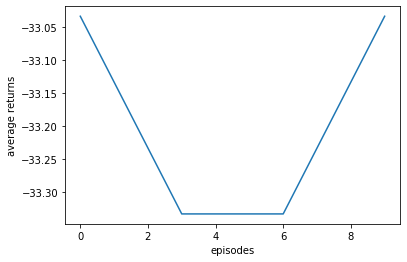

In [20]:
ppoAgent.plot_average_returns()

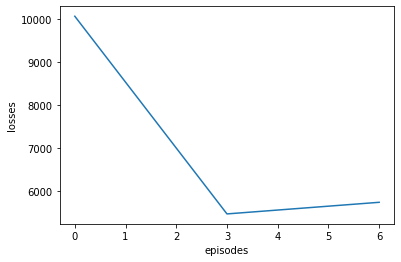

In [21]:
ppoAgent.plot_losses()

## 2. First training (with chosen policy network layers, training durations & default logging)

In [ ]:
from easyagents.tfagents import PpoAgent
from easyagents.config import TrainingDuration

In [24]:
training_duration=TrainingDuration( num_iterations = 50,
                                    num_episodes_per_iteration = 10,
                                    max_steps_per_episode = 1000,
                                    num_epochs_per_iteration = 5,
                                    num_iterations_between_eval = 10,
                                    num_eval_episodes = 10 )

In [25]:
ppoAgent = PpoAgent(    gym_env_name = 'Berater-v1',
                        fc_layers=(500,500,500), 
                        training_duration=training_duration )
ppoAgent.train()

I0624 23:23:32.575278 22948 agents.py:60] gym_env_name=Berater-v1 fc_layers=(500, 500, 500)
I0624 23:23:32.576375 22948 agents.py:69] executing: tf.compat.v1.enable_v2_behavior()
I0624 23:23:32.578297 22948 agents.py:69] executing: tf.enable_eager_execution()
I0624 23:23:32.579704 22948 agents.py:69] executing: tf.compat.v1.set_random_seed(0)
I0624 23:23:32.580279 22948 agents.py:69] Creating environment:
I0624 23:23:32.581384 22948 agents.py:69]    executing tf_py_environment.TFPyEnvironment( suite_gym.load )
I0624 23:23:32.585394 22948 agents.py:69] Creating agent:
I0624 23:23:32.586099 22948 agents.py:69]   creating  tf.compat.v1.train.AdamOptimizer( ... )
I0624 23:23:32.592112 22948 agents.py:69]   creating  PPOAgent( ... )
I0624 23:23:32.604208 22948 agents.py:69]   executing tf_agent.initialize()
I0624 23:23:32.605191 22948 agents.py:69] Creating data collection:
I0624 23:23:32.605191 22948 agents.py:69]   creating TFUniformReplayBuffer()
I0624 23:23:32.628186 22948 agents.py:69]

ppo_agent.py: creating PPOAgent(...)


I0624 23:23:34.208884 22948 logenv.py:75] #5   1.201 [R=  -3.2] game over
I0624 23:23:35.837425 22948 logenv.py:75] #5   2.201 [R=  -3.0] game over
I0624 23:23:37.374526 22948 logenv.py:75] #5   3.201 [R=  -3.3] game over
I0624 23:23:38.975446 22948 logenv.py:75] #5   4.201 [R=  -3.2] game over
I0624 23:23:40.563221 22948 logenv.py:75] #5   5.201 [R=  -3.2] game over
I0624 23:23:42.135339 22948 logenv.py:75] #5   6.201 [R=  -3.3] game over
I0624 23:23:43.604231 22948 logenv.py:75] #5   7.201 [R=  -1.7] game over
I0624 23:23:45.161143 22948 logenv.py:75] #5   8.201 [R=  -2.8] game over
I0624 23:23:46.647231 22948 logenv.py:75] #5   9.201 [R=  -3.2] game over
I0624 23:23:48.122108 22948 logenv.py:75] #5  10.201 [R=  -3.3] game over
I0624 23:23:48.125166 22948 agents.py:69] completed compute_avg_return(...) = -3.100
I0624 23:23:48.126106 22948 agents.py:69] training 1 of 50: executing collect_driver.run()
I0624 23:23:48.595163 15100 logenv.py:72] #EnvId ResetCount.Steps [R=sumRewards]
I06

ppo_agent.py: executing _train(...)
ppo_agent.py: epoch=0
ppo_agent.py: epoch=1
ppo_agent.py: epoch=2
ppo_agent.py: epoch=3
ppo_agent.py: epoch=4
ppo_agent.py: executing _train(...)
ppo_agent.py: epoch=0
ppo_agent.py: epoch=1
ppo_agent.py: epoch=2
ppo_agent.py: epoch=3
ppo_agent.py: epoch=4


I0624 23:24:01.268658 22948 agents.py:69] training 1 of 50: completed tf_agent.train(...) = 4479.675 [loss]
I0624 23:24:01.270255 22948 agents.py:69] training 1 of 50: executing replay_buffer.clear()
I0624 23:24:01.271238 22948 agents.py:69] training 2 of 50: executing collect_driver.run()
I0624 23:24:01.273164  3344 logenv.py:75] #4  11.0   [R=   0.0] executing reset(...)
I0624 23:24:01.513897  3344 logenv.py:75] #4  12.201 [R= -14.4] game over
I0624 23:24:01.729017  2520 logenv.py:75] #4  13.179 [R= -12.4] game over
I0624 23:24:01.794328 21464 logenv.py:75] #4  14.52  [R=  -3.0] game over
I0624 23:24:01.903247 10108 logenv.py:75] #4  15.90  [R=  -5.1] game over
I0624 23:24:01.984466 21464 logenv.py:75] #4  16.62  [R=  -3.2] game over
I0624 23:24:02.130287 10108 logenv.py:75] #4  17.127 [R=  -7.4] game over
I0624 23:24:02.337376 21464 logenv.py:75] #4  18.172 [R= -17.0] game over
I0624 23:24:02.495942 10108 logenv.py:75] #4  19.128 [R=  -8.1] game over
I0624 23:24:02.743566 10108 loge

ppo_agent.py: executing _train(...)
ppo_agent.py: epoch=0
ppo_agent.py: epoch=1
ppo_agent.py: epoch=2


KeyboardInterrupt: 

### Visualize

In [ ]:
ppoAgent.plot_average_returns()

In [ ]:
ppoAgent.plot_losses()

## 3. Full training (full duration, learning rate, reduced logging)

In [31]:
from easyagents.tfagents import PpoAgent
from easyagents.config import TrainingDuration
from easyagents.config import Logging

In [32]:
training_duration=TrainingDuration( num_iterations = 2000,
                                    num_episodes_per_iteration = 10,
                                    max_steps_per_episode = 1000,
                                    num_epochs_per_iteration = 5,
                                    num_iterations_between_eval = 10,
                                    num_eval_episodes = 10 )

In [34]:
logging=Logging(log_agent=True, log_gym_env=False)

In [ ]:
ppoAgent = PpoAgent(    gym_env_name = 'Berater-v1',
                        fc_layers=(500,500,500), 
                        training_duration=training_duration,
                        logging=logging,
                        learning_rate=1e-4
                   )
ppoAgent.train()

I0624 23:29:41.855004 22948 agents.py:60] gym_env_name=Berater-v1 fc_layers=(500, 500, 500)
I0624 23:29:41.856101 22948 agents.py:69] executing: tf.compat.v1.enable_v2_behavior()
I0624 23:29:41.857016 22948 agents.py:69] executing: tf.enable_eager_execution()
I0624 23:29:41.858005 22948 agents.py:69] executing: tf.compat.v1.set_random_seed(0)
I0624 23:29:41.862042 22948 agents.py:69] Creating environment:
I0624 23:29:41.863085 22948 agents.py:69]    executing tf_py_environment.TFPyEnvironment( suite_gym.load )
I0624 23:29:41.867750 22948 agents.py:69] Creating agent:
I0624 23:29:41.868785 22948 agents.py:69]   creating  tf.compat.v1.train.AdamOptimizer( ... )
I0624 23:29:41.876369 22948 agents.py:69]   creating  PPOAgent( ... )
I0624 23:29:41.888335 22948 agents.py:69]   executing tf_agent.initialize()
I0624 23:29:41.889336 22948 agents.py:69] Creating data collection:
I0624 23:29:41.889336 22948 agents.py:69]   creating TFUniformReplayBuffer()
I0624 23:29:41.910668 22948 agents.py:69]

ppo_agent.py: creating PPOAgent(...)


I0624 23:29:57.431318 22948 agents.py:69] completed compute_avg_return(...) = -3.888
I0624 23:29:57.433272 22948 agents.py:69] training 1 of 2000: executing collect_driver.run()
I0624 23:29:59.586188 22948 agents.py:69] training 1 of 2000: executing replay_buffer.gather_all()
I0624 23:29:59.591236 22948 agents.py:69] training 1 of 2000: executing tf_agent.train(...)


ppo_agent.py: executing _train(...)
ppo_agent.py: epoch=0
ppo_agent.py: epoch=1
ppo_agent.py: epoch=2
ppo_agent.py: epoch=3
ppo_agent.py: epoch=4
ppo_agent.py: executing _train(...)
ppo_agent.py: epoch=0
ppo_agent.py: epoch=1
ppo_agent.py: epoch=2
ppo_agent.py: epoch=3
ppo_agent.py: epoch=4


I0624 23:30:11.015911 22948 agents.py:69] training 1 of 2000: completed tf_agent.train(...) = 4128.440 [loss]
I0624 23:30:11.016751 22948 agents.py:69] training 1 of 2000: executing replay_buffer.clear()
I0624 23:30:11.019767 22948 agents.py:69] training 2 of 2000: executing collect_driver.run()
I0624 23:30:12.246863 22948 agents.py:69] training 2 of 2000: executing replay_buffer.gather_all()
I0624 23:30:12.249863 22948 agents.py:69] training 2 of 2000: executing tf_agent.train(...)


ppo_agent.py: executing _train(...)
ppo_agent.py: epoch=0
ppo_agent.py: epoch=1
ppo_agent.py: epoch=2
ppo_agent.py: epoch=3
ppo_agent.py: epoch=4


I0624 23:30:18.574217 22948 agents.py:69] training 2 of 2000: completed tf_agent.train(...) = 5826.175 [loss]
I0624 23:30:18.576298 22948 agents.py:69] training 2 of 2000: executing replay_buffer.clear()
I0624 23:30:18.578305 22948 agents.py:69] training 3 of 2000: executing collect_driver.run()
I0624 23:30:19.644215 22948 agents.py:69] training 3 of 2000: executing replay_buffer.gather_all()
I0624 23:30:19.650166 22948 agents.py:69] training 3 of 2000: executing tf_agent.train(...)


ppo_agent.py: executing _train(...)
ppo_agent.py: epoch=0
ppo_agent.py: epoch=1
ppo_agent.py: epoch=2
ppo_agent.py: epoch=3
ppo_agent.py: epoch=4


I0624 23:30:27.618613 22948 agents.py:69] training 3 of 2000: completed tf_agent.train(...) = 3630.698 [loss]
I0624 23:30:27.620484 22948 agents.py:69] training 3 of 2000: executing replay_buffer.clear()
I0624 23:30:27.622563 22948 agents.py:69] training 4 of 2000: executing collect_driver.run()
I0624 23:30:28.466400 22948 agents.py:69] training 4 of 2000: executing replay_buffer.gather_all()
I0624 23:30:28.470656 22948 agents.py:69] training 4 of 2000: executing tf_agent.train(...)
I0624 23:30:30.612318 22948 agents.py:69] training 4 of 2000: completed tf_agent.train(...) = 2066.112 [loss]
I0624 23:30:30.615139 22948 agents.py:69] training 4 of 2000: executing replay_buffer.clear()
I0624 23:30:30.616261 22948 agents.py:69] training 5 of 2000: executing collect_driver.run()
I0624 23:30:31.877067 22948 agents.py:69] training 5 of 2000: executing replay_buffer.gather_all()
I0624 23:30:31.880934 22948 agents.py:69] training 5 of 2000: executing tf_agent.train(...)
I0624 23:30:34.124992 22

I0624 23:31:24.358513 22948 agents.py:69] training 20 of 2000: executing collect_driver.run()
I0624 23:31:24.848925 22948 agents.py:69] training 20 of 2000: executing replay_buffer.gather_all()
I0624 23:31:24.852054 22948 agents.py:69] training 20 of 2000: executing tf_agent.train(...)
I0624 23:31:26.161526 22948 agents.py:69] training 20 of 2000: completed tf_agent.train(...) = 380.253 [loss]
I0624 23:31:26.162526 22948 agents.py:69] training 20 of 2000: executing replay_buffer.clear()
I0624 23:31:26.164525 22948 agents.py:69] executing compute_avg_return(...)
I0624 23:31:35.020688 22948 agents.py:69] completed compute_avg_return(...) = -3.267
I0624 23:31:35.021529 22948 agents.py:69] training 21 of 2000: executing collect_driver.run()
I0624 23:31:35.349219 22948 agents.py:69] training 21 of 2000: executing replay_buffer.gather_all()
I0624 23:31:35.352220 22948 agents.py:69] training 21 of 2000: executing tf_agent.train(...)
I0624 23:31:36.614161 22948 agents.py:69] training 21 of 200

I0624 23:32:07.258520 22948 agents.py:69] training 36 of 2000: executing replay_buffer.gather_all()
I0624 23:32:07.261487 22948 agents.py:69] training 36 of 2000: executing tf_agent.train(...)
I0624 23:32:08.541453 22948 agents.py:69] training 36 of 2000: completed tf_agent.train(...) = 72.798 [loss]
I0624 23:32:08.542457 22948 agents.py:69] training 36 of 2000: executing replay_buffer.clear()
I0624 23:32:08.543454 22948 agents.py:69] training 37 of 2000: executing collect_driver.run()
I0624 23:32:08.821324 22948 agents.py:69] training 37 of 2000: executing replay_buffer.gather_all()
I0624 23:32:08.824326 22948 agents.py:69] training 37 of 2000: executing tf_agent.train(...)
I0624 23:32:10.093856 22948 agents.py:69] training 37 of 2000: completed tf_agent.train(...) = 59.172 [loss]
I0624 23:32:10.095476 22948 agents.py:69] training 37 of 2000: executing replay_buffer.clear()
I0624 23:32:10.096465 22948 agents.py:69] training 38 of 2000: executing collect_driver.run()
I0624 23:32:10.449

I0624 23:32:53.128631 22948 agents.py:69] training 52 of 2000: executing tf_agent.train(...)
I0624 23:32:54.408232 22948 agents.py:69] training 52 of 2000: completed tf_agent.train(...) = 118.696 [loss]
I0624 23:32:54.409232 22948 agents.py:69] training 52 of 2000: executing replay_buffer.clear()
I0624 23:32:54.410234 22948 agents.py:69] training 53 of 2000: executing collect_driver.run()
I0624 23:32:54.594535 22948 agents.py:69] training 53 of 2000: executing replay_buffer.gather_all()
I0624 23:32:54.597492 22948 agents.py:69] training 53 of 2000: executing tf_agent.train(...)
I0624 23:32:55.786458 22948 agents.py:69] training 53 of 2000: completed tf_agent.train(...) = 50.315 [loss]
I0624 23:32:55.787443 22948 agents.py:69] training 53 of 2000: executing replay_buffer.clear()
I0624 23:32:55.789440 22948 agents.py:69] training 54 of 2000: executing collect_driver.run()
I0624 23:32:55.987658 22948 agents.py:69] training 54 of 2000: executing replay_buffer.gather_all()
I0624 23:32:55.99

I0624 23:33:24.747669 22948 agents.py:69] training 68 of 2000: executing replay_buffer.clear()
I0624 23:33:24.749670 22948 agents.py:69] training 69 of 2000: executing collect_driver.run()
I0624 23:33:24.990671 22948 agents.py:69] training 69 of 2000: executing replay_buffer.gather_all()
I0624 23:33:24.993669 22948 agents.py:69] training 69 of 2000: executing tf_agent.train(...)
I0624 23:33:26.241714 22948 agents.py:69] training 69 of 2000: completed tf_agent.train(...) = 34.296 [loss]
I0624 23:33:26.242713 22948 agents.py:69] training 69 of 2000: executing replay_buffer.clear()
I0624 23:33:26.243848 22948 agents.py:69] training 70 of 2000: executing collect_driver.run()
I0624 23:33:26.412421 22948 agents.py:69] training 70 of 2000: executing replay_buffer.gather_all()
I0624 23:33:26.414381 22948 agents.py:69] training 70 of 2000: executing tf_agent.train(...)
I0624 23:33:27.664072 22948 agents.py:69] training 70 of 2000: completed tf_agent.train(...) = 43.763 [loss]
I0624 23:33:27.665

I0624 23:34:06.059476 22948 agents.py:69] training 85 of 2000: executing collect_driver.run()
I0624 23:34:06.253449 22948 agents.py:69] training 85 of 2000: executing replay_buffer.gather_all()
I0624 23:34:06.256952 22948 agents.py:69] training 85 of 2000: executing tf_agent.train(...)
I0624 23:34:07.675308 22948 agents.py:69] training 85 of 2000: completed tf_agent.train(...) = 17.596 [loss]
I0624 23:34:07.676433 22948 agents.py:69] training 85 of 2000: executing replay_buffer.clear()
I0624 23:34:07.678311 22948 agents.py:69] training 86 of 2000: executing collect_driver.run()
I0624 23:34:07.806330 22948 agents.py:69] training 86 of 2000: executing replay_buffer.gather_all()
I0624 23:34:07.809330 22948 agents.py:69] training 86 of 2000: executing tf_agent.train(...)
I0624 23:34:09.072879 22948 agents.py:69] training 86 of 2000: completed tf_agent.train(...) = 24.925 [loss]
I0624 23:34:09.074880 22948 agents.py:69] training 86 of 2000: executing replay_buffer.clear()
I0624 23:34:09.077

I0624 23:34:57.193612 22948 agents.py:69] training 101 of 2000: executing replay_buffer.gather_all()
I0624 23:34:57.197609 22948 agents.py:69] training 101 of 2000: executing tf_agent.train(...)
I0624 23:34:59.097719 22948 agents.py:69] training 101 of 2000: completed tf_agent.train(...) = 14.413 [loss]
I0624 23:34:59.099725 22948 agents.py:69] training 101 of 2000: executing replay_buffer.clear()
I0624 23:34:59.102722 22948 agents.py:69] training 102 of 2000: executing collect_driver.run()
I0624 23:34:59.349222 22948 agents.py:69] training 102 of 2000: executing replay_buffer.gather_all()
I0624 23:34:59.354189 22948 agents.py:69] training 102 of 2000: executing tf_agent.train(...)
I0624 23:35:01.315632 22948 agents.py:69] training 102 of 2000: completed tf_agent.train(...) = 12.975 [loss]
I0624 23:35:01.317691 22948 agents.py:69] training 102 of 2000: executing replay_buffer.clear()
I0624 23:35:01.318616 22948 agents.py:69] training 103 of 2000: executing collect_driver.run()
I0624 23

I0624 23:35:38.569967 22948 agents.py:69] training 117 of 2000: executing tf_agent.train(...)
I0624 23:35:38.737944 22948 agents.py:69] training 117 of 2000: completed tf_agent.train(...) = 11.656 [loss]
I0624 23:35:38.739476 22948 agents.py:69] training 117 of 2000: executing replay_buffer.clear()
I0624 23:35:38.740942 22948 agents.py:69] training 118 of 2000: executing collect_driver.run()
I0624 23:35:38.991543 22948 agents.py:69] training 118 of 2000: executing replay_buffer.gather_all()
I0624 23:35:38.995601 22948 agents.py:69] training 118 of 2000: executing tf_agent.train(...)
I0624 23:35:39.161142 22948 agents.py:69] training 118 of 2000: completed tf_agent.train(...) = 24.511 [loss]
I0624 23:35:39.163142 22948 agents.py:69] training 118 of 2000: executing replay_buffer.clear()
I0624 23:35:39.166148 22948 agents.py:69] training 119 of 2000: executing collect_driver.run()
I0624 23:35:39.355225 22948 agents.py:69] training 119 of 2000: executing replay_buffer.gather_all()
I0624 23

I0624 23:36:21.987508 22948 agents.py:69] training 133 of 2000: executing tf_agent.train(...)
I0624 23:36:22.136469 22948 agents.py:69] training 133 of 2000: completed tf_agent.train(...) = 7.264 [loss]
I0624 23:36:22.137468 22948 agents.py:69] training 133 of 2000: executing replay_buffer.clear()
I0624 23:36:22.139571 22948 agents.py:69] training 134 of 2000: executing collect_driver.run()
I0624 23:36:22.352569 22948 agents.py:69] training 134 of 2000: executing replay_buffer.gather_all()
I0624 23:36:22.357518 22948 agents.py:69] training 134 of 2000: executing tf_agent.train(...)
I0624 23:36:24.418032 22948 agents.py:69] training 134 of 2000: completed tf_agent.train(...) = 8.234 [loss]
I0624 23:36:24.420037 22948 agents.py:69] training 134 of 2000: executing replay_buffer.clear()
I0624 23:36:24.422495 22948 agents.py:69] training 135 of 2000: executing collect_driver.run()
I0624 23:36:24.625412 22948 agents.py:69] training 135 of 2000: executing replay_buffer.gather_all()
I0624 23:3

I0624 23:36:56.269406 22948 agents.py:69] training 149 of 2000: executing replay_buffer.clear()
I0624 23:36:56.271404 22948 agents.py:69] training 150 of 2000: executing collect_driver.run()
I0624 23:36:56.443517 22948 agents.py:69] training 150 of 2000: executing replay_buffer.gather_all()
I0624 23:36:56.448183 22948 agents.py:69] training 150 of 2000: executing tf_agent.train(...)
I0624 23:36:58.473295 22948 agents.py:69] training 150 of 2000: completed tf_agent.train(...) = 5.017 [loss]
I0624 23:36:58.475293 22948 agents.py:69] training 150 of 2000: executing replay_buffer.clear()
I0624 23:36:58.477306 22948 agents.py:69] executing compute_avg_return(...)
I0624 23:37:06.566657 22948 agents.py:69] completed compute_avg_return(...) = -1.092
I0624 23:37:06.567499 22948 agents.py:69] training 151 of 2000: executing collect_driver.run()
I0624 23:37:06.767717 22948 agents.py:69] training 151 of 2000: executing replay_buffer.gather_all()
I0624 23:37:06.771718 22948 agents.py:69] training 1

I0624 23:37:39.235215 22948 agents.py:69] training 165 of 2000: executing replay_buffer.clear()
I0624 23:37:39.237210 22948 agents.py:69] training 166 of 2000: executing collect_driver.run()
I0624 23:37:39.482854 22948 agents.py:69] training 166 of 2000: executing replay_buffer.gather_all()
I0624 23:37:39.487071 22948 agents.py:69] training 166 of 2000: executing tf_agent.train(...)
I0624 23:37:41.643348 22948 agents.py:69] training 166 of 2000: completed tf_agent.train(...) = 4.806 [loss]
I0624 23:37:41.645349 22948 agents.py:69] training 166 of 2000: executing replay_buffer.clear()
I0624 23:37:41.647343 22948 agents.py:69] training 167 of 2000: executing collect_driver.run()
I0624 23:37:41.846350 22948 agents.py:69] training 167 of 2000: executing replay_buffer.gather_all()
I0624 23:37:41.851339 22948 agents.py:69] training 167 of 2000: executing tf_agent.train(...)
I0624 23:37:43.924180 22948 agents.py:69] training 167 of 2000: completed tf_agent.train(...) = 3.594 [loss]
I0624 23:3

I0624 23:38:18.469149 22948 agents.py:69] training 181 of 2000: executing replay_buffer.clear()
I0624 23:38:18.471147 22948 agents.py:69] training 182 of 2000: executing collect_driver.run()
I0624 23:38:18.813162 22948 agents.py:69] training 182 of 2000: executing replay_buffer.gather_all()
I0624 23:38:18.816201 22948 agents.py:69] training 182 of 2000: executing tf_agent.train(...)
I0624 23:38:20.985145 22948 agents.py:69] training 182 of 2000: completed tf_agent.train(...) = 66.678 [loss]
I0624 23:38:20.987141 22948 agents.py:69] training 182 of 2000: executing replay_buffer.clear()
I0624 23:38:20.989144 22948 agents.py:69] training 183 of 2000: executing collect_driver.run()
I0624 23:38:21.467165 22948 agents.py:69] training 183 of 2000: executing replay_buffer.gather_all()
I0624 23:38:21.471193 22948 agents.py:69] training 183 of 2000: executing tf_agent.train(...)
I0624 23:38:21.754357 22948 agents.py:69] training 183 of 2000: completed tf_agent.train(...) = 652.001 [loss]
I0624 2

I0624 23:38:50.842372 22948 agents.py:69] training 198 of 2000: executing replay_buffer.gather_all()
I0624 23:38:50.847443 22948 agents.py:69] training 198 of 2000: executing tf_agent.train(...)
I0624 23:38:52.926012 22948 agents.py:69] training 198 of 2000: completed tf_agent.train(...) = 11.197 [loss]
I0624 23:38:52.928022 22948 agents.py:69] training 198 of 2000: executing replay_buffer.clear()
I0624 23:38:52.929022 22948 agents.py:69] training 199 of 2000: executing collect_driver.run()
I0624 23:38:53.188045 22948 agents.py:69] training 199 of 2000: executing replay_buffer.gather_all()
I0624 23:38:53.191040 22948 agents.py:69] training 199 of 2000: executing tf_agent.train(...)
I0624 23:38:55.180074 22948 agents.py:69] training 199 of 2000: completed tf_agent.train(...) = 14.742 [loss]
I0624 23:38:55.181073 22948 agents.py:69] training 199 of 2000: executing replay_buffer.clear()
I0624 23:38:55.184077 22948 agents.py:69] training 200 of 2000: executing collect_driver.run()
I0624 23

I0624 23:39:24.490262 22948 agents.py:69] training 214 of 2000: executing replay_buffer.gather_all()
I0624 23:39:24.495155 22948 agents.py:69] training 214 of 2000: executing tf_agent.train(...)
I0624 23:39:26.519559 22948 agents.py:69] training 214 of 2000: completed tf_agent.train(...) = 4.836 [loss]
I0624 23:39:26.521787 22948 agents.py:69] training 214 of 2000: executing replay_buffer.clear()
I0624 23:39:26.523558 22948 agents.py:69] training 215 of 2000: executing collect_driver.run()
I0624 23:39:26.708050 22948 agents.py:69] training 215 of 2000: executing replay_buffer.gather_all()
I0624 23:39:26.711050 22948 agents.py:69] training 215 of 2000: executing tf_agent.train(...)
I0624 23:39:28.763599 22948 agents.py:69] training 215 of 2000: completed tf_agent.train(...) = 5.975 [loss]
I0624 23:39:28.765599 22948 agents.py:69] training 215 of 2000: executing replay_buffer.clear()
I0624 23:39:28.767920 22948 agents.py:69] training 216 of 2000: executing collect_driver.run()
I0624 23:3

I0624 23:39:53.939437 22948 agents.py:69] training 230 of 2000: completed tf_agent.train(...) = 3.112 [loss]
I0624 23:39:53.940436 22948 agents.py:69] training 230 of 2000: executing replay_buffer.clear()
I0624 23:39:53.942440 22948 agents.py:69] executing compute_avg_return(...)
I0624 23:40:01.735562 22948 agents.py:69] completed compute_avg_return(...) = -0.780
I0624 23:40:01.737562 22948 agents.py:69] training 231 of 2000: executing collect_driver.run()
I0624 23:40:01.921282 22948 agents.py:69] training 231 of 2000: executing replay_buffer.gather_all()
I0624 23:40:01.927279 22948 agents.py:69] training 231 of 2000: executing tf_agent.train(...)
I0624 23:40:02.136833 22948 agents.py:69] training 231 of 2000: completed tf_agent.train(...) = 4.776 [loss]
I0624 23:40:02.138838 22948 agents.py:69] training 231 of 2000: executing replay_buffer.clear()
I0624 23:40:02.140837 22948 agents.py:69] training 232 of 2000: executing collect_driver.run()
I0624 23:40:02.338562 22948 agents.py:69] tr

I0624 23:40:28.043822 22948 agents.py:69] training 246 of 2000: completed tf_agent.train(...) = 11.429 [loss]
I0624 23:40:28.044748 22948 agents.py:69] training 246 of 2000: executing replay_buffer.clear()
I0624 23:40:28.046863 22948 agents.py:69] training 247 of 2000: executing collect_driver.run()
I0624 23:40:28.316354 22948 agents.py:69] training 247 of 2000: executing replay_buffer.gather_all()
I0624 23:40:28.319365 22948 agents.py:69] training 247 of 2000: executing tf_agent.train(...)
I0624 23:40:30.638318 22948 agents.py:69] training 247 of 2000: completed tf_agent.train(...) = 10.736 [loss]
I0624 23:40:30.640317 22948 agents.py:69] training 247 of 2000: executing replay_buffer.clear()
I0624 23:40:30.641320 22948 agents.py:69] training 248 of 2000: executing collect_driver.run()
I0624 23:40:30.890276 22948 agents.py:69] training 248 of 2000: executing replay_buffer.gather_all()
I0624 23:40:30.894276 22948 agents.py:69] training 248 of 2000: executing tf_agent.train(...)
I0624 23

I0624 23:40:57.028361 22948 agents.py:69] training 262 of 2000: completed tf_agent.train(...) = 3.070 [loss]
I0624 23:40:57.030427 22948 agents.py:69] training 262 of 2000: executing replay_buffer.clear()
I0624 23:40:57.032364 22948 agents.py:69] training 263 of 2000: executing collect_driver.run()
I0624 23:40:57.215652 22948 agents.py:69] training 263 of 2000: executing replay_buffer.gather_all()
I0624 23:40:57.218951 22948 agents.py:69] training 263 of 2000: executing tf_agent.train(...)
I0624 23:40:57.454804 22948 agents.py:69] training 263 of 2000: completed tf_agent.train(...) = 6.191 [loss]
I0624 23:40:57.456345 22948 agents.py:69] training 263 of 2000: executing replay_buffer.clear()
I0624 23:40:57.458401 22948 agents.py:69] training 264 of 2000: executing collect_driver.run()
I0624 23:40:57.673714 22948 agents.py:69] training 264 of 2000: executing replay_buffer.gather_all()
I0624 23:40:57.677309 22948 agents.py:69] training 264 of 2000: executing tf_agent.train(...)
I0624 23:4

I0624 23:41:21.363386 22948 agents.py:69] training 279 of 2000: executing collect_driver.run()
I0624 23:41:21.622896 22948 agents.py:69] training 279 of 2000: executing replay_buffer.gather_all()
I0624 23:41:21.626883 22948 agents.py:69] training 279 of 2000: executing tf_agent.train(...)
I0624 23:41:21.886829 22948 agents.py:69] training 279 of 2000: completed tf_agent.train(...) = 22.349 [loss]
I0624 23:41:21.888827 22948 agents.py:69] training 279 of 2000: executing replay_buffer.clear()
I0624 23:41:21.891828 22948 agents.py:69] training 280 of 2000: executing collect_driver.run()
I0624 23:41:22.087825 22948 agents.py:69] training 280 of 2000: executing replay_buffer.gather_all()
I0624 23:41:22.092823 22948 agents.py:69] training 280 of 2000: executing tf_agent.train(...)
I0624 23:41:22.334595 22948 agents.py:69] training 280 of 2000: completed tf_agent.train(...) = 2.828 [loss]
I0624 23:41:22.335721 22948 agents.py:69] training 280 of 2000: executing replay_buffer.clear()
I0624 23:

I0624 23:41:47.465474 22948 agents.py:69] training 295 of 2000: executing collect_driver.run()
I0624 23:41:47.639211 22948 agents.py:69] training 295 of 2000: executing replay_buffer.gather_all()
I0624 23:41:47.644227 22948 agents.py:69] training 295 of 2000: executing tf_agent.train(...)
I0624 23:41:49.986758 22948 agents.py:69] training 295 of 2000: completed tf_agent.train(...) = 1.429 [loss]
I0624 23:41:49.988759 22948 agents.py:69] training 295 of 2000: executing replay_buffer.clear()
I0624 23:41:49.989762 22948 agents.py:69] training 296 of 2000: executing collect_driver.run()
I0624 23:41:50.170161 22948 agents.py:69] training 296 of 2000: executing replay_buffer.gather_all()
I0624 23:41:50.175119 22948 agents.py:69] training 296 of 2000: executing tf_agent.train(...)
I0624 23:41:50.447449 22948 agents.py:69] training 296 of 2000: completed tf_agent.train(...) = 3.098 [loss]
I0624 23:41:50.448451 22948 agents.py:69] training 296 of 2000: executing replay_buffer.clear()
I0624 23:4

I0624 23:42:13.085183 22948 agents.py:69] training 311 of 2000: executing collect_driver.run()
I0624 23:42:13.334156 22948 agents.py:69] training 311 of 2000: executing replay_buffer.gather_all()
I0624 23:42:13.338159 22948 agents.py:69] training 311 of 2000: executing tf_agent.train(...)
I0624 23:42:13.586273 22948 agents.py:69] training 311 of 2000: completed tf_agent.train(...) = 2.412 [loss]
I0624 23:42:13.589079 22948 agents.py:69] training 311 of 2000: executing replay_buffer.clear()
I0624 23:42:13.590283 22948 agents.py:69] training 312 of 2000: executing collect_driver.run()
I0624 23:42:13.816943 22948 agents.py:69] training 312 of 2000: executing replay_buffer.gather_all()
I0624 23:42:13.820732 22948 agents.py:69] training 312 of 2000: executing tf_agent.train(...)
I0624 23:42:14.086432 22948 agents.py:69] training 312 of 2000: completed tf_agent.train(...) = 2.271 [loss]
I0624 23:42:14.088624 22948 agents.py:69] training 312 of 2000: executing replay_buffer.clear()
I0624 23:4

I0624 23:42:32.419265 22948 agents.py:69] training 327 of 2000: executing tf_agent.train(...)
I0624 23:42:32.672405 22948 agents.py:69] training 327 of 2000: completed tf_agent.train(...) = 16.660 [loss]
I0624 23:42:32.674153 22948 agents.py:69] training 327 of 2000: executing replay_buffer.clear()
I0624 23:42:32.676086 22948 agents.py:69] training 328 of 2000: executing collect_driver.run()
I0624 23:42:32.852756 22948 agents.py:69] training 328 of 2000: executing replay_buffer.gather_all()
I0624 23:42:32.856860 22948 agents.py:69] training 328 of 2000: executing tf_agent.train(...)
I0624 23:42:33.106337 22948 agents.py:69] training 328 of 2000: completed tf_agent.train(...) = 2.059 [loss]
I0624 23:42:33.107167 22948 agents.py:69] training 328 of 2000: executing replay_buffer.clear()
I0624 23:42:33.110170 22948 agents.py:69] training 329 of 2000: executing collect_driver.run()
I0624 23:42:33.277541 22948 agents.py:69] training 329 of 2000: executing replay_buffer.gather_all()
I0624 23:

I0624 23:42:56.714163 22948 agents.py:69] training 343 of 2000: executing tf_agent.train(...)
I0624 23:42:56.987075 22948 agents.py:69] training 343 of 2000: completed tf_agent.train(...) = 5.352 [loss]
I0624 23:42:56.988074 22948 agents.py:69] training 343 of 2000: executing replay_buffer.clear()
I0624 23:42:56.990075 22948 agents.py:69] training 344 of 2000: executing collect_driver.run()
I0624 23:42:57.189771 22948 agents.py:69] training 344 of 2000: executing replay_buffer.gather_all()
I0624 23:42:57.194735 22948 agents.py:69] training 344 of 2000: executing tf_agent.train(...)
I0624 23:42:57.473607 22948 agents.py:69] training 344 of 2000: completed tf_agent.train(...) = 3.148 [loss]
I0624 23:42:57.476707 22948 agents.py:69] training 344 of 2000: executing replay_buffer.clear()
I0624 23:42:57.478417 22948 agents.py:69] training 345 of 2000: executing collect_driver.run()
I0624 23:42:57.672827 22948 agents.py:69] training 345 of 2000: executing replay_buffer.gather_all()
I0624 23:4

I0624 23:43:15.129128 22948 agents.py:69] training 359 of 2000: executing replay_buffer.clear()
I0624 23:43:15.130118 22948 agents.py:69] training 360 of 2000: executing collect_driver.run()
I0624 23:43:15.415124 22948 agents.py:69] training 360 of 2000: executing replay_buffer.gather_all()
I0624 23:43:15.419124 22948 agents.py:69] training 360 of 2000: executing tf_agent.train(...)
I0624 23:43:15.671732 22948 agents.py:69] training 360 of 2000: completed tf_agent.train(...) = 33.846 [loss]
I0624 23:43:15.672733 22948 agents.py:69] training 360 of 2000: executing replay_buffer.clear()
I0624 23:43:15.674735 22948 agents.py:69] executing compute_avg_return(...)
I0624 23:43:22.882349 22948 agents.py:69] completed compute_avg_return(...) = -0.519
I0624 23:43:22.883336 22948 agents.py:69] training 361 of 2000: executing collect_driver.run()
I0624 23:43:23.098340 22948 agents.py:69] training 361 of 2000: executing replay_buffer.gather_all()
I0624 23:43:23.101390 22948 agents.py:69] training 

I0624 23:43:36.980003 22948 agents.py:69] training 375 of 2000: executing replay_buffer.clear()
I0624 23:43:36.983016 22948 agents.py:69] training 376 of 2000: executing collect_driver.run()
I0624 23:43:37.190006 22948 agents.py:69] training 376 of 2000: executing replay_buffer.gather_all()
I0624 23:43:37.194038 22948 agents.py:69] training 376 of 2000: executing tf_agent.train(...)
I0624 23:43:37.472204 22948 agents.py:69] training 376 of 2000: completed tf_agent.train(...) = 4.980 [loss]
I0624 23:43:37.474212 22948 agents.py:69] training 376 of 2000: executing replay_buffer.clear()
I0624 23:43:37.476384 22948 agents.py:69] training 377 of 2000: executing collect_driver.run()
I0624 23:43:37.701400 22948 agents.py:69] training 377 of 2000: executing replay_buffer.gather_all()
I0624 23:43:37.709366 22948 agents.py:69] training 377 of 2000: executing tf_agent.train(...)
I0624 23:43:38.022799 22948 agents.py:69] training 377 of 2000: completed tf_agent.train(...) = 1.585 [loss]
I0624 23:4

I0624 23:43:56.510617 22948 agents.py:69] training 391 of 2000: executing replay_buffer.clear()
I0624 23:43:56.511617 22948 agents.py:69] training 392 of 2000: executing collect_driver.run()
I0624 23:43:56.714825 22948 agents.py:69] training 392 of 2000: executing replay_buffer.gather_all()
I0624 23:43:56.718400 22948 agents.py:69] training 392 of 2000: executing tf_agent.train(...)
I0624 23:43:56.975015 22948 agents.py:69] training 392 of 2000: completed tf_agent.train(...) = 2.533 [loss]
I0624 23:43:56.977175 22948 agents.py:69] training 392 of 2000: executing replay_buffer.clear()
I0624 23:43:56.978738 22948 agents.py:69] training 393 of 2000: executing collect_driver.run()
I0624 23:43:57.130886 22948 agents.py:69] training 393 of 2000: executing replay_buffer.gather_all()
I0624 23:43:57.135883 22948 agents.py:69] training 393 of 2000: executing tf_agent.train(...)
I0624 23:43:59.516464 22948 agents.py:69] training 393 of 2000: completed tf_agent.train(...) = 1.864 [loss]
I0624 23:4

I0624 23:44:10.326574 22948 agents.py:69] training 408 of 2000: executing replay_buffer.gather_all()
I0624 23:44:10.331614 22948 agents.py:69] training 408 of 2000: executing tf_agent.train(...)
I0624 23:44:12.685308 22948 agents.py:69] training 408 of 2000: completed tf_agent.train(...) = 2.560 [loss]
I0624 23:44:12.687304 22948 agents.py:69] training 408 of 2000: executing replay_buffer.clear()
I0624 23:44:12.689728 22948 agents.py:69] training 409 of 2000: executing collect_driver.run()
I0624 23:44:12.867892 22948 agents.py:69] training 409 of 2000: executing replay_buffer.gather_all()
I0624 23:44:12.871886 22948 agents.py:69] training 409 of 2000: executing tf_agent.train(...)
I0624 23:44:13.130556 22948 agents.py:69] training 409 of 2000: completed tf_agent.train(...) = 1.150 [loss]
I0624 23:44:13.132556 22948 agents.py:69] training 409 of 2000: executing replay_buffer.clear()
I0624 23:44:13.135560 22948 agents.py:69] training 410 of 2000: executing collect_driver.run()
I0624 23:4

I0624 23:44:29.224010 22948 agents.py:69] training 424 of 2000: executing replay_buffer.gather_all()
I0624 23:44:29.227012 22948 agents.py:69] training 424 of 2000: executing tf_agent.train(...)
I0624 23:44:31.625929 22948 agents.py:69] training 424 of 2000: completed tf_agent.train(...) = 2.589 [loss]
I0624 23:44:31.628927 22948 agents.py:69] training 424 of 2000: executing replay_buffer.clear()
I0624 23:44:31.630930 22948 agents.py:69] training 425 of 2000: executing collect_driver.run()
I0624 23:44:31.877498 22948 agents.py:69] training 425 of 2000: executing replay_buffer.gather_all()
I0624 23:44:31.884729 22948 agents.py:69] training 425 of 2000: executing tf_agent.train(...)
I0624 23:44:32.188371 22948 agents.py:69] training 425 of 2000: completed tf_agent.train(...) = 4.853 [loss]
I0624 23:44:32.190765 22948 agents.py:69] training 425 of 2000: executing replay_buffer.clear()
I0624 23:44:32.192768 22948 agents.py:69] training 426 of 2000: executing collect_driver.run()
I0624 23:4

I0624 23:44:47.271882 22948 agents.py:69] training 440 of 2000: completed tf_agent.train(...) = 1.216 [loss]
I0624 23:44:47.273884 22948 agents.py:69] training 440 of 2000: executing replay_buffer.clear()
I0624 23:44:47.276881 22948 agents.py:69] executing compute_avg_return(...)
I0624 23:44:51.727025 22948 agents.py:69] completed compute_avg_return(...) = 0.149
I0624 23:44:51.728025 22948 agents.py:69] training 441 of 2000: executing collect_driver.run()
I0624 23:44:52.001717 22948 agents.py:69] training 441 of 2000: executing replay_buffer.gather_all()
I0624 23:44:52.006676 22948 agents.py:69] training 441 of 2000: executing tf_agent.train(...)
I0624 23:44:52.335680 22948 agents.py:69] training 441 of 2000: completed tf_agent.train(...) = 2.852 [loss]
I0624 23:44:52.337671 22948 agents.py:69] training 441 of 2000: executing replay_buffer.clear()
I0624 23:44:52.340758 22948 agents.py:69] training 442 of 2000: executing collect_driver.run()
I0624 23:44:52.552672 22948 agents.py:69] tra

I0624 23:45:08.213008 22948 agents.py:69] training 456 of 2000: completed tf_agent.train(...) = 0.803 [loss]
I0624 23:45:08.215010 22948 agents.py:69] training 456 of 2000: executing replay_buffer.clear()
I0624 23:45:08.218005 22948 agents.py:69] training 457 of 2000: executing collect_driver.run()
I0624 23:45:08.424006 22948 agents.py:69] training 457 of 2000: executing replay_buffer.gather_all()
I0624 23:45:08.428007 22948 agents.py:69] training 457 of 2000: executing tf_agent.train(...)
I0624 23:45:10.739247 22948 agents.py:69] training 457 of 2000: completed tf_agent.train(...) = 0.674 [loss]
I0624 23:45:10.740246 22948 agents.py:69] training 457 of 2000: executing replay_buffer.clear()
I0624 23:45:10.742249 22948 agents.py:69] training 458 of 2000: executing collect_driver.run()
I0624 23:45:10.898286 22948 agents.py:69] training 458 of 2000: executing replay_buffer.gather_all()
I0624 23:45:10.902285 22948 agents.py:69] training 458 of 2000: executing tf_agent.train(...)
I0624 23:4

I0624 23:45:29.241983 22948 agents.py:69] training 472 of 2000: completed tf_agent.train(...) = 0.912 [loss]
I0624 23:45:29.243979 22948 agents.py:69] training 472 of 2000: executing replay_buffer.clear()
I0624 23:45:29.246988 22948 agents.py:69] training 473 of 2000: executing collect_driver.run()
I0624 23:45:29.485617 22948 agents.py:69] training 473 of 2000: executing replay_buffer.gather_all()
I0624 23:45:29.488649 22948 agents.py:69] training 473 of 2000: executing tf_agent.train(...)
I0624 23:45:29.781621 22948 agents.py:69] training 473 of 2000: completed tf_agent.train(...) = 5.938 [loss]
I0624 23:45:29.783621 22948 agents.py:69] training 473 of 2000: executing replay_buffer.clear()
I0624 23:45:29.785822 22948 agents.py:69] training 474 of 2000: executing collect_driver.run()
I0624 23:45:30.014400 22948 agents.py:69] training 474 of 2000: executing replay_buffer.gather_all()
I0624 23:45:30.021428 22948 agents.py:69] training 474 of 2000: executing tf_agent.train(...)
I0624 23:4

I0624 23:45:41.009072 22948 agents.py:69] training 489 of 2000: executing collect_driver.run()
I0624 23:45:41.205583 22948 agents.py:69] training 489 of 2000: executing replay_buffer.gather_all()
I0624 23:45:41.207625 22948 agents.py:69] training 489 of 2000: executing tf_agent.train(...)
I0624 23:45:41.478537 22948 agents.py:69] training 489 of 2000: completed tf_agent.train(...) = 1.291 [loss]
I0624 23:45:41.480532 22948 agents.py:69] training 489 of 2000: executing replay_buffer.clear()
I0624 23:45:41.483539 22948 agents.py:69] training 490 of 2000: executing collect_driver.run()
I0624 23:45:41.673019 22948 agents.py:69] training 490 of 2000: executing replay_buffer.gather_all()
I0624 23:45:41.679032 22948 agents.py:69] training 490 of 2000: executing tf_agent.train(...)
I0624 23:45:42.001021 22948 agents.py:69] training 490 of 2000: completed tf_agent.train(...) = 2.785 [loss]
I0624 23:45:42.002509 22948 agents.py:69] training 490 of 2000: executing replay_buffer.clear()
I0624 23:4

I0624 23:46:01.107223 22948 agents.py:69] training 505 of 2000: executing collect_driver.run()
I0624 23:46:01.344309 22948 agents.py:69] training 505 of 2000: executing replay_buffer.gather_all()
I0624 23:46:01.350323 22948 agents.py:69] training 505 of 2000: executing tf_agent.train(...)
I0624 23:46:01.661800 22948 agents.py:69] training 505 of 2000: completed tf_agent.train(...) = 2.793 [loss]
I0624 23:46:01.663793 22948 agents.py:69] training 505 of 2000: executing replay_buffer.clear()
I0624 23:46:01.666815 22948 agents.py:69] training 506 of 2000: executing collect_driver.run()
I0624 23:46:01.859800 22948 agents.py:69] training 506 of 2000: executing replay_buffer.gather_all()
I0624 23:46:01.864223 22948 agents.py:69] training 506 of 2000: executing tf_agent.train(...)
I0624 23:46:02.158431 22948 agents.py:69] training 506 of 2000: completed tf_agent.train(...) = 1.458 [loss]
I0624 23:46:02.160440 22948 agents.py:69] training 506 of 2000: executing replay_buffer.clear()
I0624 23:4

I0624 23:46:23.680043 22948 agents.py:69] training 521 of 2000: executing collect_driver.run()
I0624 23:46:23.859052 22948 agents.py:69] training 521 of 2000: executing replay_buffer.gather_all()
I0624 23:46:23.864042 22948 agents.py:69] training 521 of 2000: executing tf_agent.train(...)
I0624 23:46:24.148359 22948 agents.py:69] training 521 of 2000: completed tf_agent.train(...) = 1.943 [loss]
I0624 23:46:24.150359 22948 agents.py:69] training 521 of 2000: executing replay_buffer.clear()
I0624 23:46:24.152690 22948 agents.py:69] training 522 of 2000: executing collect_driver.run()
I0624 23:46:24.323413 22948 agents.py:69] training 522 of 2000: executing replay_buffer.gather_all()
I0624 23:46:24.326410 22948 agents.py:69] training 522 of 2000: executing tf_agent.train(...)
I0624 23:46:24.602094 22948 agents.py:69] training 522 of 2000: completed tf_agent.train(...) = 1.301 [loss]
I0624 23:46:24.603094 22948 agents.py:69] training 522 of 2000: executing replay_buffer.clear()
I0624 23:4

I0624 23:46:36.373093 22948 agents.py:69] training 537 of 2000: executing tf_agent.train(...)
I0624 23:46:36.704377 22948 agents.py:69] training 537 of 2000: completed tf_agent.train(...) = 2.121 [loss]
I0624 23:46:36.706377 22948 agents.py:69] training 537 of 2000: executing replay_buffer.clear()
I0624 23:46:36.707377 22948 agents.py:69] training 538 of 2000: executing collect_driver.run()
I0624 23:46:36.882389 22948 agents.py:69] training 538 of 2000: executing replay_buffer.gather_all()
I0624 23:46:36.886383 22948 agents.py:69] training 538 of 2000: executing tf_agent.train(...)
I0624 23:46:37.259377 22948 agents.py:69] training 538 of 2000: completed tf_agent.train(...) = 1.248 [loss]
I0624 23:46:37.260378 22948 agents.py:69] training 538 of 2000: executing replay_buffer.clear()
I0624 23:46:37.264377 22948 agents.py:69] training 539 of 2000: executing collect_driver.run()
I0624 23:46:37.455380 22948 agents.py:69] training 539 of 2000: executing replay_buffer.gather_all()
I0624 23:4

I0624 23:46:52.781285 22948 agents.py:69] training 553 of 2000: executing tf_agent.train(...)
I0624 23:46:53.020277 22948 agents.py:69] training 553 of 2000: completed tf_agent.train(...) = 0.899 [loss]
I0624 23:46:53.022281 22948 agents.py:69] training 553 of 2000: executing replay_buffer.clear()
I0624 23:46:53.024277 22948 agents.py:69] training 554 of 2000: executing collect_driver.run()
I0624 23:46:53.175278 22948 agents.py:69] training 554 of 2000: executing replay_buffer.gather_all()
I0624 23:46:53.178279 22948 agents.py:69] training 554 of 2000: executing tf_agent.train(...)
I0624 23:46:53.440782 22948 agents.py:69] training 554 of 2000: completed tf_agent.train(...) = 0.875 [loss]
I0624 23:46:53.441775 22948 agents.py:69] training 554 of 2000: executing replay_buffer.clear()
I0624 23:46:53.443780 22948 agents.py:69] training 555 of 2000: executing collect_driver.run()
I0624 23:46:53.605046 22948 agents.py:69] training 555 of 2000: executing replay_buffer.gather_all()
I0624 23:4

I0624 23:47:01.664616 22948 agents.py:69] training 569 of 2000: executing replay_buffer.clear()
I0624 23:47:01.666621 22948 agents.py:69] training 570 of 2000: executing collect_driver.run()
I0624 23:47:01.792556 22948 agents.py:69] training 570 of 2000: executing replay_buffer.gather_all()
I0624 23:47:01.796507 22948 agents.py:69] training 570 of 2000: executing tf_agent.train(...)
I0624 23:47:02.057571 22948 agents.py:69] training 570 of 2000: completed tf_agent.train(...) = 0.546 [loss]
I0624 23:47:02.059731 22948 agents.py:69] training 570 of 2000: executing replay_buffer.clear()
I0624 23:47:02.060577 22948 agents.py:69] executing compute_avg_return(...)
I0624 23:47:03.584346 22948 agents.py:69] completed compute_avg_return(...) = 0.686
I0624 23:47:03.587342 22948 agents.py:69] training 571 of 2000: executing collect_driver.run()
I0624 23:47:03.883564 22948 agents.py:69] training 571 of 2000: executing replay_buffer.gather_all()
I0624 23:47:03.887575 22948 agents.py:69] training 57

I0624 23:47:14.406603 22948 agents.py:69] training 585 of 2000: executing replay_buffer.clear()
I0624 23:47:14.408523 22948 agents.py:69] training 586 of 2000: executing collect_driver.run()
I0624 23:47:14.575988 22948 agents.py:69] training 586 of 2000: executing replay_buffer.gather_all()
I0624 23:47:14.578985 22948 agents.py:69] training 586 of 2000: executing tf_agent.train(...)
I0624 23:47:14.848747 22948 agents.py:69] training 586 of 2000: completed tf_agent.train(...) = 0.472 [loss]
I0624 23:47:14.850746 22948 agents.py:69] training 586 of 2000: executing replay_buffer.clear()
I0624 23:47:14.851875 22948 agents.py:69] training 587 of 2000: executing collect_driver.run()
I0624 23:47:15.009432 22948 agents.py:69] training 587 of 2000: executing replay_buffer.gather_all()
I0624 23:47:15.013347 22948 agents.py:69] training 587 of 2000: executing tf_agent.train(...)
I0624 23:47:15.287536 22948 agents.py:69] training 587 of 2000: completed tf_agent.train(...) = 0.573 [loss]
I0624 23:4

I0624 23:47:35.726181 22948 agents.py:69] training 601 of 2000: executing replay_buffer.clear()
I0624 23:47:35.727736 22948 agents.py:69] training 602 of 2000: executing collect_driver.run()
I0624 23:47:35.928500 22948 agents.py:69] training 602 of 2000: executing replay_buffer.gather_all()
I0624 23:47:35.931451 22948 agents.py:69] training 602 of 2000: executing tf_agent.train(...)
I0624 23:47:36.214546 22948 agents.py:69] training 602 of 2000: completed tf_agent.train(...) = 0.657 [loss]
I0624 23:47:36.215550 22948 agents.py:69] training 602 of 2000: executing replay_buffer.clear()
I0624 23:47:36.217677 22948 agents.py:69] training 603 of 2000: executing collect_driver.run()
I0624 23:47:36.455031 22948 agents.py:69] training 603 of 2000: executing replay_buffer.gather_all()
I0624 23:47:36.459798 22948 agents.py:69] training 603 of 2000: executing tf_agent.train(...)
I0624 23:47:36.736712 22948 agents.py:69] training 603 of 2000: completed tf_agent.train(...) = 0.812 [loss]
I0624 23:4

I0624 23:47:46.433727 22948 agents.py:69] training 618 of 2000: executing replay_buffer.gather_all()
I0624 23:47:46.436689 22948 agents.py:69] training 618 of 2000: executing tf_agent.train(...)
I0624 23:47:46.713146 22948 agents.py:69] training 618 of 2000: completed tf_agent.train(...) = 13.129 [loss]
I0624 23:47:46.714147 22948 agents.py:69] training 618 of 2000: executing replay_buffer.clear()
I0624 23:47:46.716148 22948 agents.py:69] training 619 of 2000: executing collect_driver.run()
I0624 23:47:46.873100 22948 agents.py:69] training 619 of 2000: executing replay_buffer.gather_all()
I0624 23:47:46.877783 22948 agents.py:69] training 619 of 2000: executing tf_agent.train(...)
I0624 23:47:47.140288 22948 agents.py:69] training 619 of 2000: completed tf_agent.train(...) = 0.895 [loss]
I0624 23:47:47.143287 22948 agents.py:69] training 619 of 2000: executing replay_buffer.clear()
I0624 23:47:47.145288 22948 agents.py:69] training 620 of 2000: executing collect_driver.run()
I0624 23:

I0624 23:48:13.306820 22948 agents.py:69] training 634 of 2000: executing replay_buffer.gather_all()
I0624 23:48:13.310861 22948 agents.py:69] training 634 of 2000: executing tf_agent.train(...)
I0624 23:48:13.543643 22948 agents.py:69] training 634 of 2000: completed tf_agent.train(...) = 17.081 [loss]
I0624 23:48:13.544551 22948 agents.py:69] training 634 of 2000: executing replay_buffer.clear()
I0624 23:48:13.545549 22948 agents.py:69] training 635 of 2000: executing collect_driver.run()
I0624 23:48:13.701255 22948 agents.py:69] training 635 of 2000: executing replay_buffer.gather_all()
I0624 23:48:13.704219 22948 agents.py:69] training 635 of 2000: executing tf_agent.train(...)
I0624 23:48:13.928554 22948 agents.py:69] training 635 of 2000: completed tf_agent.train(...) = 10.200 [loss]
I0624 23:48:13.929536 22948 agents.py:69] training 635 of 2000: executing replay_buffer.clear()
I0624 23:48:13.931535 22948 agents.py:69] training 636 of 2000: executing collect_driver.run()
I0624 23

I0624 23:48:25.019938 22948 agents.py:69] training 650 of 2000: completed tf_agent.train(...) = 25.781 [loss]
I0624 23:48:25.020934 22948 agents.py:69] training 650 of 2000: executing replay_buffer.clear()
I0624 23:48:25.023942 22948 agents.py:69] executing compute_avg_return(...)
I0624 23:48:25.755285 22948 agents.py:69] completed compute_avg_return(...) = 0.652
I0624 23:48:25.756272 22948 agents.py:69] training 651 of 2000: executing collect_driver.run()
I0624 23:48:25.875773 22948 agents.py:69] training 651 of 2000: executing replay_buffer.gather_all()
I0624 23:48:25.877772 22948 agents.py:69] training 651 of 2000: executing tf_agent.train(...)
I0624 23:48:26.090619 22948 agents.py:69] training 651 of 2000: completed tf_agent.train(...) = 12.203 [loss]
I0624 23:48:26.091619 22948 agents.py:69] training 651 of 2000: executing replay_buffer.clear()
I0624 23:48:26.093620 22948 agents.py:69] training 652 of 2000: executing collect_driver.run()
I0624 23:48:26.337610 22948 agents.py:69] t

I0624 23:48:37.144398 22948 agents.py:69] training 666 of 2000: completed tf_agent.train(...) = 4.669 [loss]
I0624 23:48:37.146472 22948 agents.py:69] training 666 of 2000: executing replay_buffer.clear()
I0624 23:48:37.148398 22948 agents.py:69] training 667 of 2000: executing collect_driver.run()
I0624 23:48:37.289731 22948 agents.py:69] training 667 of 2000: executing replay_buffer.gather_all()
I0624 23:48:37.293601 22948 agents.py:69] training 667 of 2000: executing tf_agent.train(...)
I0624 23:48:37.534844 22948 agents.py:69] training 667 of 2000: completed tf_agent.train(...) = 3.586 [loss]
I0624 23:48:37.536353 22948 agents.py:69] training 667 of 2000: executing replay_buffer.clear()
I0624 23:48:37.537840 22948 agents.py:69] training 668 of 2000: executing collect_driver.run()
I0624 23:48:37.721325 22948 agents.py:69] training 668 of 2000: executing replay_buffer.gather_all()
I0624 23:48:37.724329 22948 agents.py:69] training 668 of 2000: executing tf_agent.train(...)
I0624 23:4

### Visualize

In [ ]:
ppoAgent.plot_average_returns()

In [ ]:
ppoAgent.plot_losses()